In [1]:
import pandas as pd
import numpy as np
import h5py
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from sklearn.metrics import roc_auc_score
import time
import copy
from tqdm.auto import tqdm
import torch.optim as optim
import os
import sys

In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[2]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
experiment_num = 14

In [4]:
with h5py.File('../../../data/3d_array/mod_test_data_3d_h5.h5', 'r') as f:
    test_X = f['test_data_3d'][:]
test_y = pd.read_parquet('../../../data/3d_array/test_targets.parquet')

test_X = np.nan_to_num(test_X, nan=0.0)

In [5]:
test_y['end_of_month'].value_counts()

end_of_month
2018-03-31    137674
Name: count, dtype: int64

In [6]:
test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]


C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_26080\204564841.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]


In [7]:
test_y

,customer_ID,end_of_month,target
0,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-31,0
1,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-31,0
2,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-31,0
3,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,2018-03-31,0
4,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,2018-03-31,1
...,...,...,...
137669,fffee056e120fb326c9413fca5a7ab6618cc49be9bb6b1...,2018-03-31,0
137670,fffee847c5c1af7dbdd36d98fea882893256c422cde86c...,2018-03-31,0
137671,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2018-03-31,0
137672,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2018-03-31,0


In [8]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

In [ ]:
class MDC(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7], num_kernels_per_scale=3):
        super(MDC, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_sizes = kernel_sizes
        self.num_scales = len(kernel_sizes)
        self.num_kernels_per_scale = num_kernels_per_scale
        self.total_kernels = self.num_scales * self.num_kernels_per_scale

        self.attention_pool = nn.AdaptiveAvgPool1d(1) # Pool across time dimension
        # Conv1d to generate temporal attention map
        self.attention_conv = nn.Conv1d(in_channels, self.total_kernels, kernel_size=1, bias=False)
        self.attention_gap = nn.AdaptiveAvgPool1d(1) # Pool attention map to get weights
        self.attention_activation = nn.Sigmoid()

        # Store the kernels for each scale and each instance per scale
        self.weights = nn.Parameter(torch.Tensor(self.total_kernels, out_channels, in_channels, 1))
        nn.init.kaiming_uniform_(self.weights, a=np.sqrt(5)) # Initialize weights

        # Store kernel sizes correctly
        self.k_sizes = []
        for k in kernel_sizes:
            for _ in range(num_kernels_per_scale):
                self.k_sizes.append(k)

    def forward(self, x):
        batch_size, _, T = x.size()

        pooled_x = self.attention_pool(x) # B x C_in x 1
        att_gap1 = self.attention_pool(x)
        attention_map = self.attention_conv(x) # B x total_kernels x T
        attention_vector = self.attention_gap(attention_map)
        attention_weights = self.attention_activation(attention_vector) # Shape: (batch_size, total_kernels, 1)
        outputs = []
        current_kernel_idx = 0
        for k_size in self.kernel_sizes:
            padding = k_size // 2
            for i in range(self.num_kernels_per_scale):
                kernel_idx = current_kernel_idx + i
                kernel_weight = self.weights[kernel_idx] # out_c x in_c x 1
                dynamic_kernel = kernel_weight.repeat(1, 1, k_size) # out_c x in_c x k_size
                
                # Perform convolution with this specific kernel
                output_i = F.conv1d(x, dynamic_kernel, padding=padding) # B x out_c x T
                
                # Apply attention weight for this kernel
                # attention_weights[:, kernel_idx, :] shape: B x 1 x 1
                weighted_output = output_i * attention_weights[:, kernel_idx, :].unsqueeze(-1) # B x out_c x T
                outputs.append(weighted_output)
                
            current_kernel_idx += self.num_kernels_per_scale

        # Sum the weighted outputs from all kernels
        # This is an alternative interpretation to fusing weights first.
        out = torch.sum(torch.stack(outputs), dim=0) # B x out_c x T

        return out

In [ ]:
class MDCResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7], num_kernels_per_scale=3, stride=1):
        super(MDCResBlock, self).__init__()
        
        # Use Conv1d for the residual connection if dimensions change
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.mdc1 = MDC(in_channels, out_channels, kernel_sizes, num_kernels_per_scale)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.prelu1 = nn.PReLU(out_channels)

        self.mdc2 = MDC(out_channels, out_channels, kernel_sizes, num_kernels_per_scale)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.prelu2 = nn.PReLU(out_channels) # Activation after final BN before adding shortcut

    def forward(self, x):
        shortcut = self.shortcut(x)

        out = self.mdc1(x)
        out = self.bn1(out)
        out = self.prelu1(out)

        out = self.mdc2(out)
        out = self.bn2(out)

        out += shortcut
        out = self.prelu2(out) # Final activation after adding shortcut

        return out

In [ ]:
class MDCNet(nn.Module):
    def __init__(self, input_channels, num_classes, block_channels=[128, 128, 128], kernel_sizes=[3,5,7], num_kernels_per_scale=2, dropout_rate=0.3, reduction=16):
        super(MDCNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        current_channels = input_channels
        
        for i, channels in enumerate(block_channels):
            # Stride only applied if pooling happens, MaxPooling handles stride=2
            res_block = MDCResBlock(current_channels, channels, kernel_sizes, num_kernels_per_scale, stride=1)
            max_pool = nn.MaxPool1d(kernel_size=2, stride=2) # Halve the length
            se_block = SEBlock(channels, reduction) # SE block
            dropout = nn.Dropout(dropout_rate) # Dropout
            
            block = nn.Sequential(
                res_block,
                max_pool,
                se_block,
                dropout
            )
            self.blocks.append(block)
            current_channels = channels # Update channels for next block

        self.gap = nn.AdaptiveAvgPool1d(1) # Global Average Pooling
        self.output_channels = current_channels

    def forward(self, x):
        # Input x shape: B x T x C_in
        # Conv1D expects B x C_in x T
        x = x.permute(0, 2, 1) # B x C_in x T

        for block in self.blocks:
            x = block(x)

        # Global Average Pooling
        x = self.gap(x) # B x C_out x 1
        x = x.view(x.size(0), -1) # Flatten: B x C_out

        return x

In [12]:
class LSTMMDCModel(nn.Module):
    def __init__(self, input_size, time_steps, num_classes=1, 
                 mdc_block_channels=[64, 64, 64], mdc_kernel_sizes=[3,5,7], 
                 mdc_kernels_per_scale=2, dropout_rate=0.2, fc_size=32,
                 lstm_hidden_size=64, lstm_num_layers=2, lstm_dropout=0.2):
        super(LSTMMDCModel, self).__init__()
        
        # MDCNet branch
        self.mdc_net = MDCNet(input_channels=input_size,
                              num_classes=num_classes,
                              block_channels=mdc_block_channels,
                              kernel_sizes=mdc_kernel_sizes,
                              num_kernels_per_scale=mdc_kernels_per_scale,
                              dropout_rate=dropout_rate)
        
        # LSTM branch
        self.lstm = nn.LSTM(input_size=input_size, 
                           hidden_size=lstm_hidden_size,
                           num_layers=lstm_num_layers, 
                           batch_first=True,
                           dropout=lstm_dropout if lstm_num_layers > 1 else 0,
                           bidirectional=True)
        
        # Get the output feature dimensions
        mdc_output_channels = self.mdc_net.output_channels
        lstm_output_channels = lstm_hidden_size * 2  # Bidirectional LSTM
        combined_features = mdc_output_channels + lstm_output_channels
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(combined_features, fc_size)
        self.relu_fc = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(fc_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x time_steps x features
        
        # MDC branch processing
        mdc_features = self.mdc_net(x)  # Output: B x mdc_output_channels
        
        # LSTM branch processing
        # x is already in format B x T x F, which is what LSTM expects
        lstm_out, _ = self.lstm(x)  # Output: B x T x (hidden_size*2)
        
        # Take the final time step output from LSTM
        lstm_features = lstm_out[:, -1, :]  # B x (hidden_size*2)
        
        # Combine features from both branches
        combined = torch.cat([mdc_features, lstm_features], dim=1)
        
        # Fully connected layers
        x = self.fc1(combined)
        x = self.relu_fc(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Output probability
        return self.sigmoid(x)

In [13]:
# Initialize the Modified ConvModel
input_size = test_X.shape[2]  # Number of features (115)
time_steps = test_X.shape[1]  # Number of time steps (10)
output_size = 1  # Binary classification

In [ ]:
# --- MDCNet Hyperparameters ---
mdc_block_channels = [16, 32, 64] # Example channel sizes for each block
mdc_kernel_sizes = [3, 5, 7]
mdc_kernels_per_scale = 2
dropout_rate = 0.2 # Adjusted dropout
fc_size = 16 # Adjusted FC size

# LSTM parameters
lstm_hidden_size = 32
lstm_num_layers = 2
lstm_dropout = 0.2

# Create model instance
model = LSTMMDCModel(input_size=input_size,
                     time_steps=time_steps,
                     num_classes=output_size,
                     mdc_block_channels=mdc_block_channels,
                     mdc_kernel_sizes=mdc_kernel_sizes,
                     mdc_kernels_per_scale=mdc_kernels_per_scale,
                     dropout_rate=dropout_rate,
                     fc_size=fc_size,
                     lstm_hidden_size=lstm_hidden_size,
                     lstm_num_layers=lstm_num_layers,
                     lstm_dropout=lstm_dropout)

print(f"Model initialized with input_size={input_size}, output_size={output_size}")

Model initialized with input_size=86, output_size=1


In [15]:
# Define the model path
model_path = f'../../../models/deep_learning/experiment_{experiment_num}.pth'

# Load the model parameters
try:
    # Load the saved dictionary
    checkpoint = torch.load(model_path)
    
    # Extract model parameters from the 'model_state_dict' key
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model parameters loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    print("Please specify the correct path to the model parameters")
except KeyError:
    print(f"'model_state_dict' key not found in the checkpoint file")
    print("The file may have been saved with a different structure")
except Exception as e:
    print(f"Error loading model parameters: {str(e)}")

Model parameters loaded successfully from ../../../models/deep_learning/experiment_14.pth


C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_26080\148194223.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [16]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [17]:
batch_size = 10000
test_dataset = TimeSeriesDataset(test_X, test_y['target'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Set model to evaluation mode
model.eval()

# Check if CUDA is available and move model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store predictions and true values
all_preds = []
all_labels = []

# Perform inference without gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Convert predictions to binary (0 or 1) using threshold of 0.5
pred_classes = (all_preds > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Generate classification report

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, digits = 4))

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print ROC-AUC score
auc = roc_auc_score(true_classes, all_preds)
print(f"ROC-AUC Score: {auc:.4f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0     0.9193    0.9349    0.9270    102026
           1     0.8042    0.7651    0.7841     35648

    accuracy                         0.8909    137674
   macro avg     0.8617    0.8500    0.8556    137674
weighted avg     0.8895    0.8909    0.8900    137674

Accuracy: 0.8909
ROC-AUC Score: 0.9523

Confusion Matrix:
[[95384  6642]
 [ 8375 27273]]


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7376867
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8586    0.9800    0.9153    102026
     Class 1     0.9039    0.5380    0.6745     35648

    accuracy                         0.8655    137674
   macro avg     0.8812    0.7590    0.7949    137674
weighted avg     0.8703    0.8655    0.8529    137674



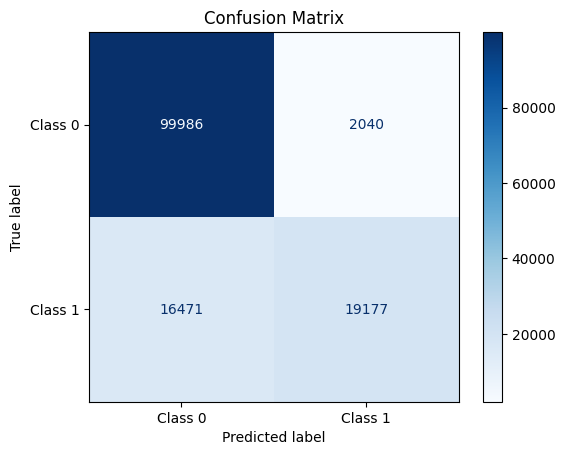

0.7376866936683655

In [20]:
from utils.eval_helpers import evaluate_model_for_recall
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=true_classes, y_pred_proba=all_preds)